# Merging tables together!

First things first, importing necessary packages and tables! 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#import csv
title_basics = pd.read_csv('data/imdb.title.basics.csv')
years = pd.read_csv('data/bothyear.csv')

# Preparing title_basics table

From the 'title_baiscs' table extracted from IMDB we are going to merge 2018 and 2019 movies together with the webscrape because we want to find which genres make the most money during a particular season. So first we want to seperate the genres in the table by ','. We then take our title basics table and only keep the 2018, 2019 movies. We also want to rename the primary_title column to just title, so that we can merge the two tables together.

In [78]:
#Let's look at your table!
title_basics.head(3)

,tconst,title,original_title,start_year,runtime_minutes,genres,genre1,genre2,genre3
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",Action,Crime,Drama
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",Biography,Drama,None
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,Drama,None,None


In [3]:
#splitting up genres by comma split
title_basics['genre1'] = title_basics['genres'].str.split(',', 1, expand=True)[0]
title_basics['genre2'] = title_basics['genres'].str.split(',', 1, expand=True)[1]
title_basics['genre3'] = title_basics['genre2'].str.split(',', 1, expand=True)[1]

In [5]:
#Since genre2 still had commas, and we split that to genre3, we can get rid of the comma
title_basics['genre2'] = title_basics['genre2'].str.split(',', 1, expand=True)[0]

In [6]:
#renaming column so that we can merge between tables
title_basics.rename(columns={'primary_title':'title'}, 
                 inplace=True)

In [7]:
#KEEPING ONLY MOVIES FROM 2018 and 2019
title_2019 = title_basics[title_basics.start_year == 2019]
title_2018 = title_basics[title_basics.start_year == 2018]
title_1819 = [title_2019,title_2018]
title1819 = pd.concat(title_1819)

In [76]:
title1819.sample(3)

,tconst,title,original_title,start_year,runtime_minutes,genres,genre1,genre2,genre3
135386,tt8574124,Repossession,Repossession,2019,96.0,"Drama,Horror",Drama,Horror,None
71668,tt4089672,No to They,No to They,2018,105.0,Thriller,Thriller,None,None
5421,tt10466358,The Roadium Mixtape Documixery,The Roadium Mixtape Documixery,2019,257.0,Documentary,Documentary,None,None


Out 'title_basics' table is now ready and has been prepared and exported to 'title1819'.

# Preparing the webscrape table 'years' 

This section, we want to prepare our 'years' table. We found that summer movies have the highest average gross. So we are going to drop all rows that do not contain summer.

In [75]:
years.head(3)

,Unnamed: 0,title,theaters,release,distributor,gross,total_gross,season_year,seasonn
1893,0,Incredibles 2,"4,410",Jun 15,Walt Disney Studios Motion Pictures\n\n,603113505,608581744,2018,Summer
1894,1,Jurassic World: Fallen Kingdom,"4,485",Jun 22,Universal Pictures\n\n,415439855,417719760,2018,Summer
1895,2,Avengers: Infinity War,"4,474",Apr 27,Walt Disney Studios Motion Pictures\n\n,340456163,678815482,2018,Summer


In [12]:
#We want only the summer movies since we found that season to have the highest average grossing movies
years.drop(years[years.seasonn != 'Summer'].index, inplace = True)

In [13]:
#Left merge the two tables, our left table being 'years'. This is the table we scrapped from BoxOfficeMojo
df_merge = pd.merge(years, title1819, on='title', how='left')

In [14]:
#We want to drop the length of movies which are null
df_merge.dropna(subset = ['runtime_minutes'], axis = 0, inplace = True)

In [15]:
#To check if the drop was successful
df_merge.isna().sum()

Unnamed: 0           0
title                0
theaters             0
release              0
distributor          0
gross                0
total_gross          0
season_year          0
seasonn              0
tconst               0
original_title       0
start_year           0
runtime_minutes      0
genres               4
genre1               4
genre2              57
genre3             102
dtype: int64

LIMITATIONS:
Because we are trying to find an answer to a specific question, we end up with 196 data points we can use. 

Now we have all of the data that we need! It's time to graph! :) 

# TIME TO GRAPH!

We want to to graph the length of movie runtime vs their average gross. We do this first by creating new parameters to categorize runtime. Our categories are: "Short" if movie runtime is under 90 minutes; "Average" if movie runtime is between 90 to 120 minutes; and "Long" if the movie is longer than 120 minutes

In [17]:
df_merge.runtime_minutes.describe()

count    196.000000
mean     103.688776
std       20.037915
min       15.000000
25%       92.000000
50%      101.000000
75%      113.250000
max      165.000000
Name: runtime_minutes, dtype: float64

In [18]:
#CATEGORIZING RUNTIME OF MOVIES: Short(runtime < 90 minutes), Average(90<runtime<120), Long(120<x)
df_merge['length_movie'] = df_merge.runtime_minutes.map(lambda x: 
                                                  'Short' if x< 90 
                                                  else('Average' 
                                                       if 90<x<120 else'Long'))

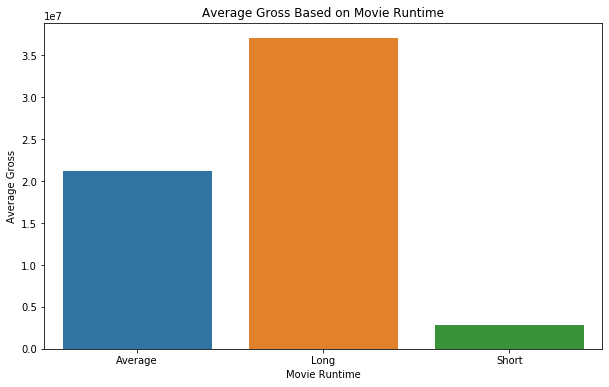

In [23]:
#Plot 
y = df_merge.groupby('length_movie').gross.mean();
x = y.index;
figure, ax = plt.subplots(figsize = (10,6));
sns.barplot(x,y);
ax.set_title('Average Gross Based on Movie Runtime');
ax.set_xlabel('Movie Runtime');
ax.set_ylabel('Average Gross');

Now we want to figure out if a movie that crosses different genres generates a higher average gross. 

In [25]:
#TO FIND HOW MANY GENRE'S EACH MOVIE HAS!!!

istrue = lambda x: x!=None
countgenres = lambda row: istrue(row['genre1']) + istrue(row['genre2']) + istrue(row['genre3'])
df_merge['num_genres'] = df_merge.apply(countgenres, axis=1)

Text(0, 0.5, 'Average Gross')

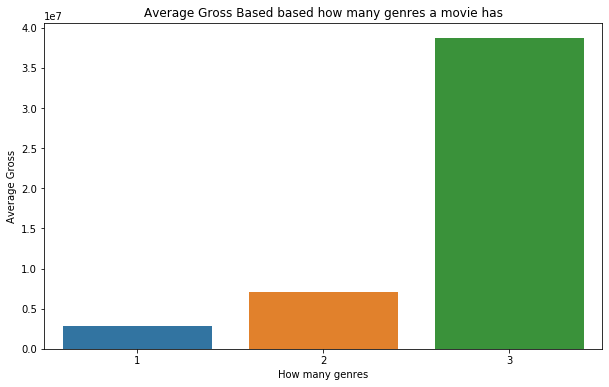

In [27]:
#Plotting how many genre's a movie crosses vs their average 
y = df_merge.groupby('num_genres').gross.mean()
x = y.index
figure, ax = plt.subplots(figsize = (10,6))
sns.barplot(x,y)
ax.set_title('Average Gross Based based how many genres a movie has')
ax.set_xlabel('How many genres')
ax.set_ylabel('Average Gross')

In [100]:
df_merge.num_genres.value_counts()

3    98
1    53
2    45
Name: num_genres, dtype: int64

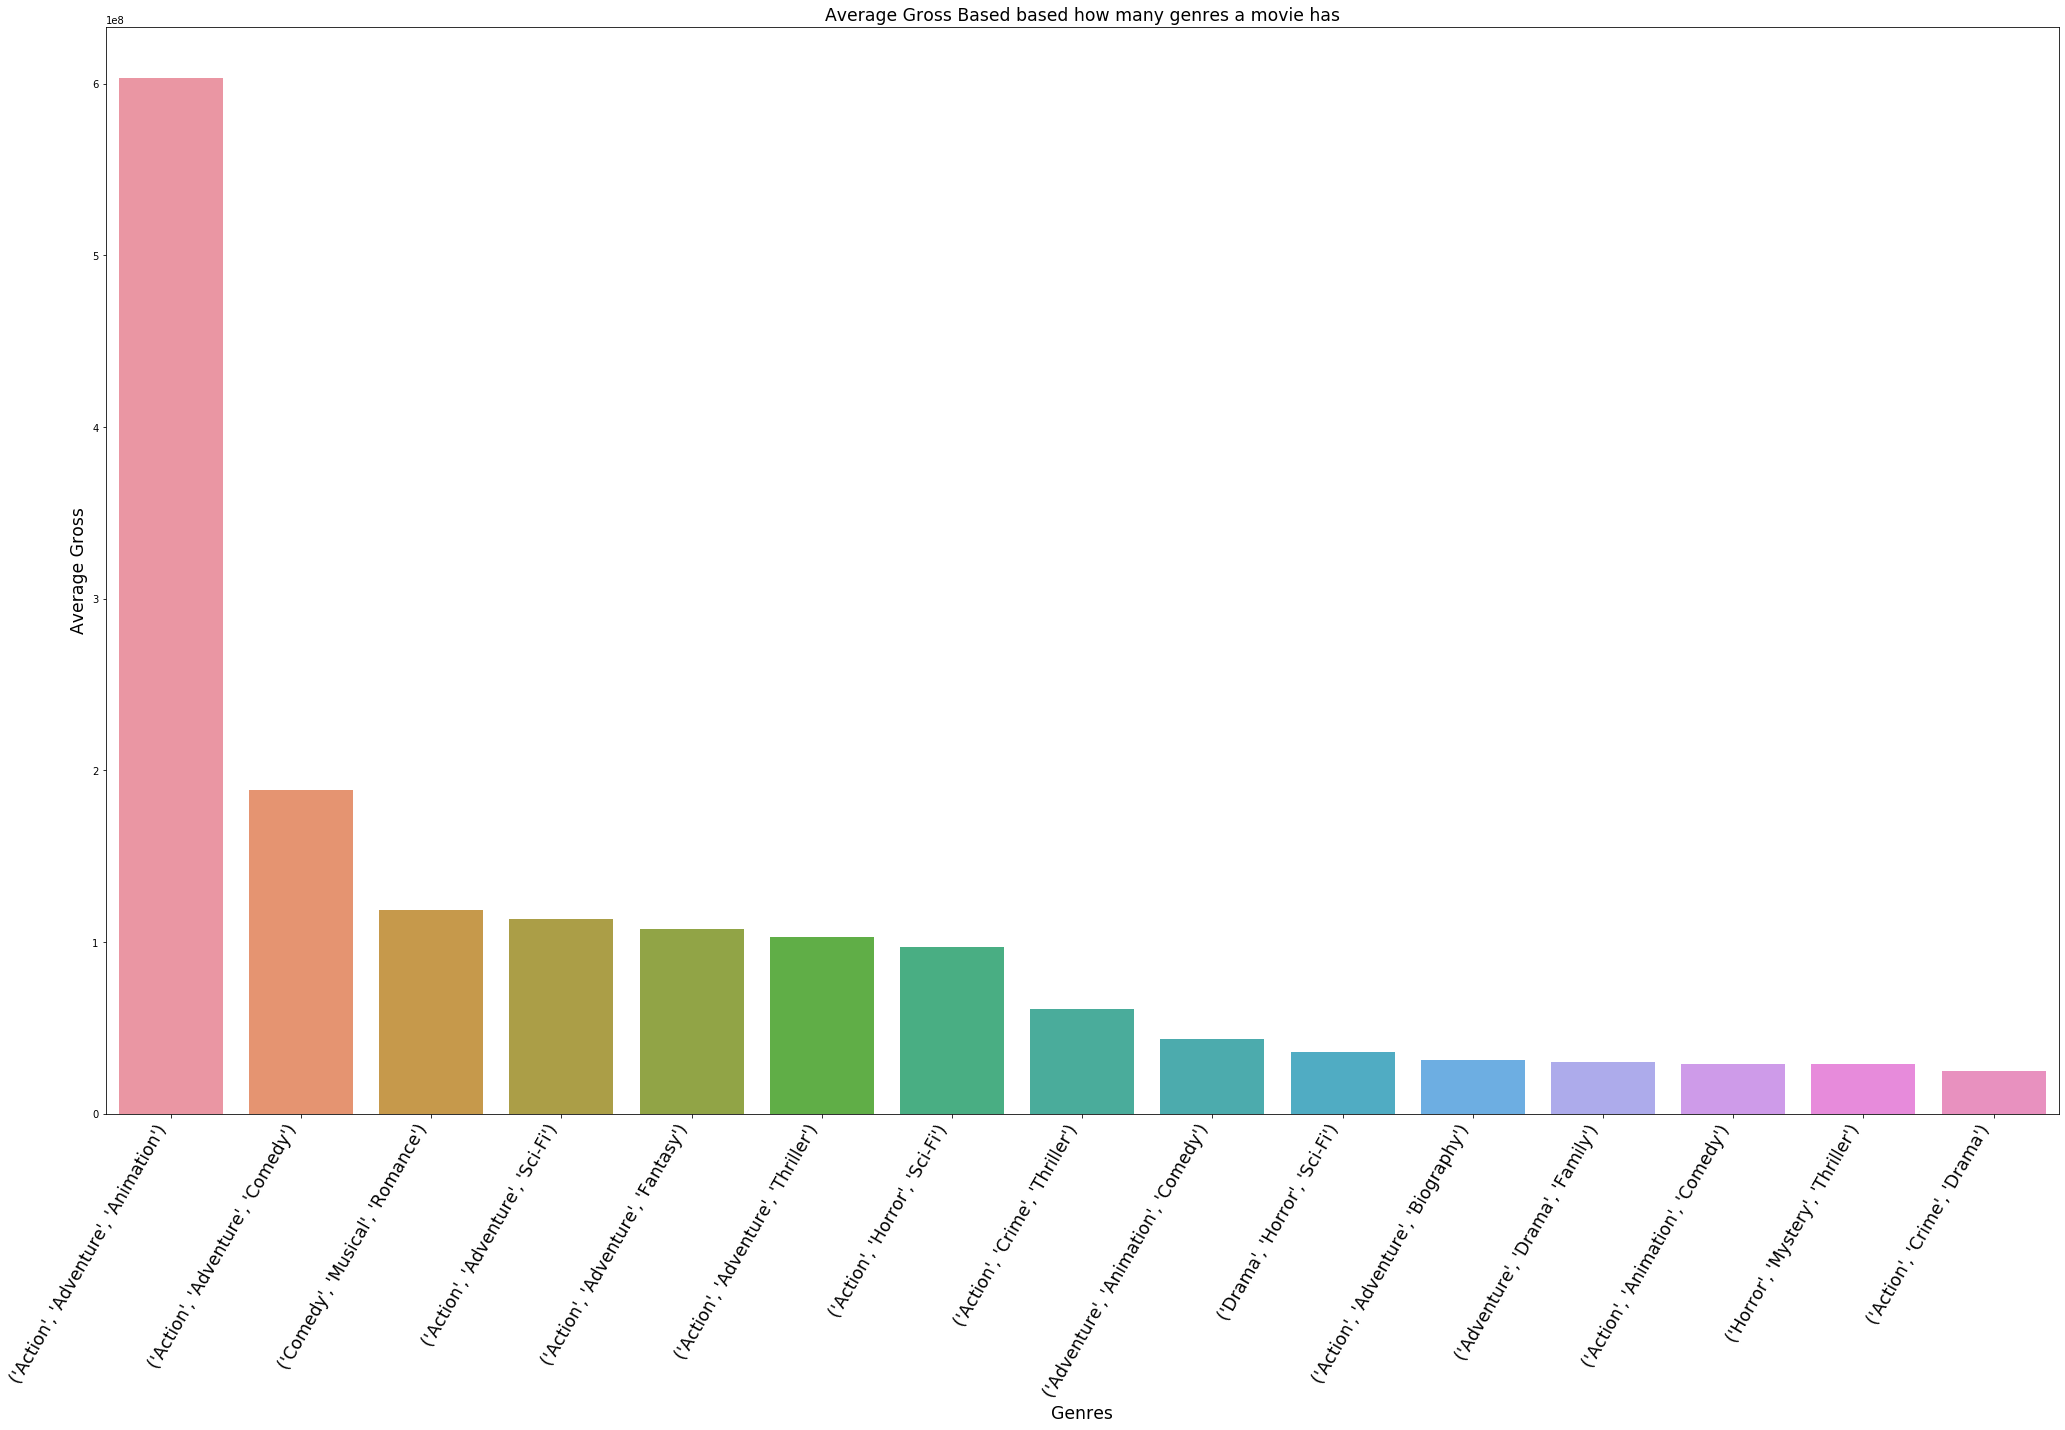

In [72]:
y = df_merge.groupby(['genre1', 'genre2', 'genre3'])['gross'].mean().sort_values(ascending = False)[:15]
x = y.index
figure, ax = plt.subplots(figsize = (35,20))
char = sns.barplot(x,y);
ax.set_title('Average Gross Based based how many genres a movie has', fontdict={'fontsize':'xx-large'})
ax.set_xlabel('Genres', fontdict={'fontsize':'xx-large'})
ax.set_ylabel('Average Gross', fontdict={'fontsize':'xx-large'})
char.set_xticklabels(
    char.get_xticklabels(), 
    rotation=60, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='xx-large');